<a href="https://colab.research.google.com/github/contrerasisaac/Personal_ML_Models/blob/main/mri_and_alzheimer's_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category = ConvergenceWarning)
simplefilter("ignore", category = UserWarning)
%matplotlib inline

sns.set()

In [1]:
# Provide your Kaggle API credentials
creds = '{"username":"isaaccontreras","key":"54643fe1fb68d705fe572f475c8af2a8"}'

# Install Kaggle API
!pip install kaggle

# Create the Kaggle directory
!mkdir ~/.kaggle

# Save your Kaggle API credentials to the correct file
with open('/content/kaggle.json', 'w') as f:
    f.write(creds)

# Move the Kaggle API credentials to the correct location
!cp /content/kaggle.json ~/.kaggle/

# Set appropriate permissions on the Kaggle API credentials file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d jboysen/mri-and-alzheimers

# Unzip the downloaded dataset
!unzip mri-and-alzheimers.zip


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [3]:
# Import Dataset (dataframe)
df = pd.read_csv('oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
# for this experiment, only the FIRST visit data is required
df = df.loc[df['Visit']==1]
# reset index after filtering first visit data
df = df.reset_index(drop=True)
# male (M)/ female (F) column
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])
# Target variable
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0])
# Clean data / Drop unnecessary columns
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1)

Text(0.5, 1.0, 'Gender and Demented')

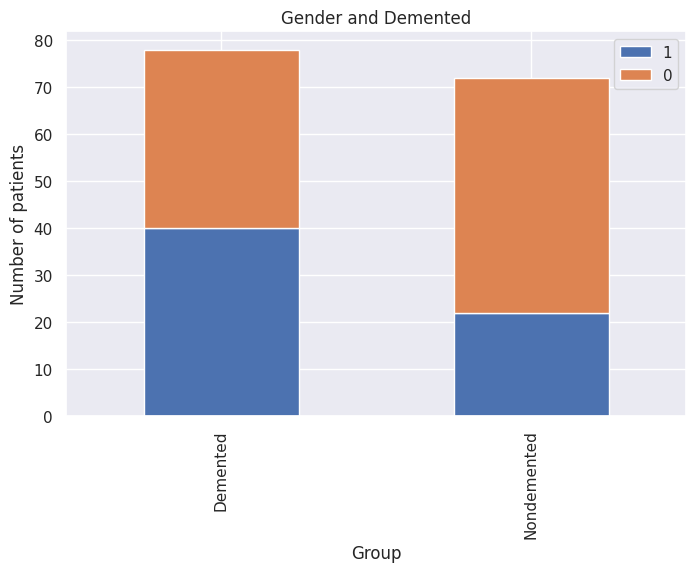

In [5]:
# funciton draws histogram
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

# Gender  and  Group ( Female=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented')

In [6]:
# Check missing values by each column
pd.isnull(df).sum()
# The column, SES (Socio-Economic Status), has 8 missing values
# removes the null values in the ses column
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

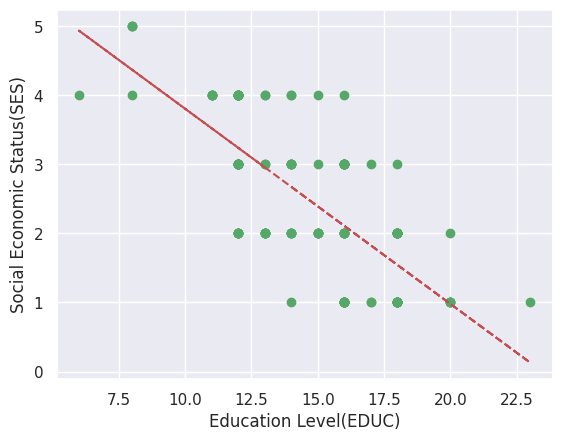

In [7]:
# Imputation
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in order to identify the correlation between the two variables
# also needed to how one variable changes with repsect to the other
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [8]:
# calculates the median SES value for each EDUC (education) group
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [9]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)
# Confirms no missing values and all 150 subject data was used
pd.isnull(df['SES']).value_counts()

False    150
Name: SES, dtype: int64

In [10]:
# Import libraries to split dataset into training/validation/test sets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [11]:
# Scaling the Dataset with imputation
# Dataset with imputation
Y = df['Group'].values # exctracts the "Group" column from the dataframe as the target variable (Y)
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # selecting the features from the df

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0) # set to 0 foro reproducibility

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval) # utilizing min-max to rescale in a specified range [0, 1]
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Scaling the Dataset excluding missing values
# Dataset after dropping missing value rows
Y = df_dropna['Group'].values # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

In [13]:
# Training model with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
acc = [] # list to store all performance metric

In [14]:
# Dataset with imputation
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])
#with warnings.catch_warnings():
    #warnings.filterwarnings("ignore", category=ConvergenceWarning)

Best accuracy on validation set is: 0.733596837944664
Best parameter for regularization (C) is:  100
Test accuracy with best C parameter is 0.7894736842105263
Test recall with the best C parameter is 0.7
Test AUC with the best C parameter is 0.7944444444444444


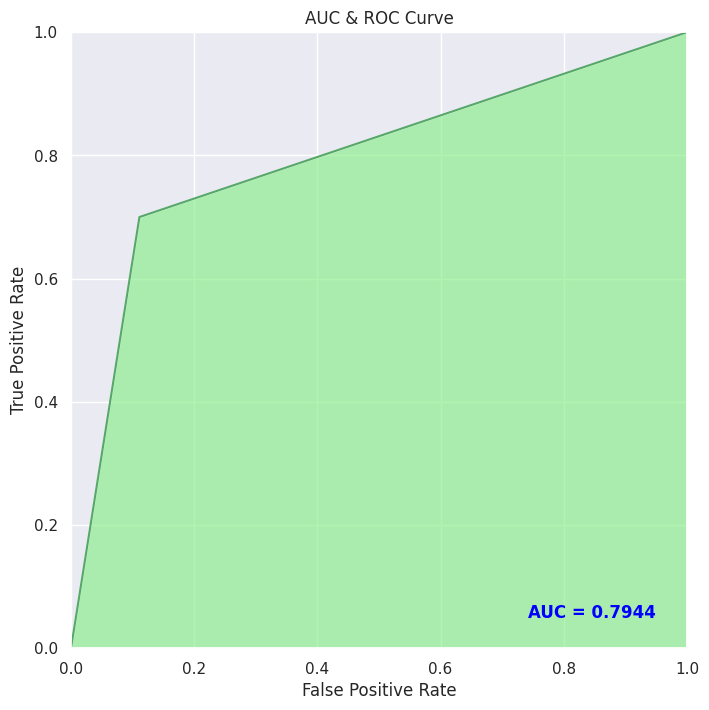

In [15]:
# Plotting AUC and ROC CURVE
from sklearn import metrics
aucm = metrics.roc_auc_score(Y_test, PredictedOutput)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(Y_test, PredictedOutput)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % aucm, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [16]:
# Logistic Regression Model without Imputation
# Dataset after dropping missing value rows
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval_scaled_dna, Y_trainval_dna, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled_dna, Y_trainval_dna)

test_score = SelectedLogRegModel.score(X_test_scaled_dna, Y_test_dna)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)

m = 'Logistic Regression (w/ dropna)'
acc.append([m, test_score, test_recall, test_recall, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.725974025974026
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.8055555555555556
Test recall with the best C parameter is 0.75
Test AUC with the best C parameter is 0.8194444444444443


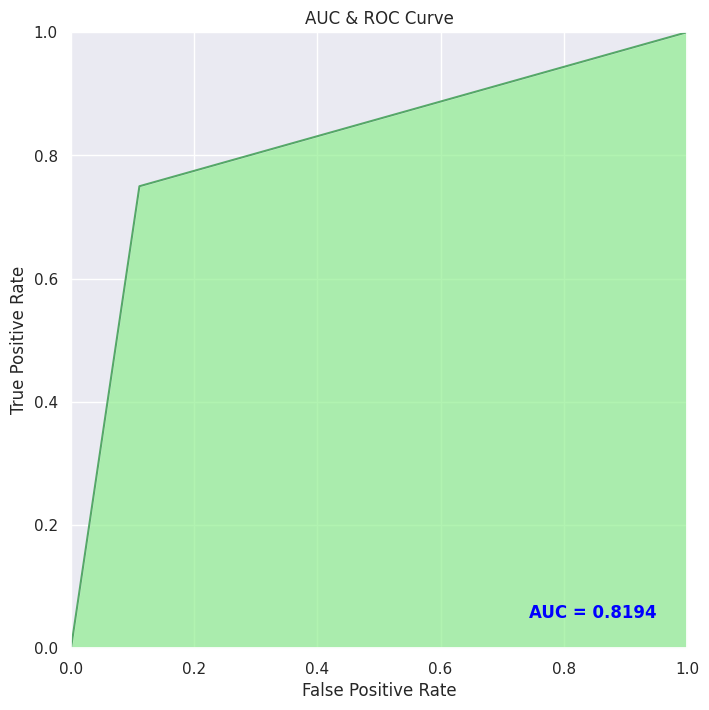

In [17]:
# Plotting AUC and ROC CURVE (for model w/out Imputation)
from sklearn import metrics
aucm = metrics.roc_auc_score(Y_test, PredictedOutput)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(Y_test, PredictedOutput)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % aucm, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [18]:
# Decision Tree Model
best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval )

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.7770750988142293
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825


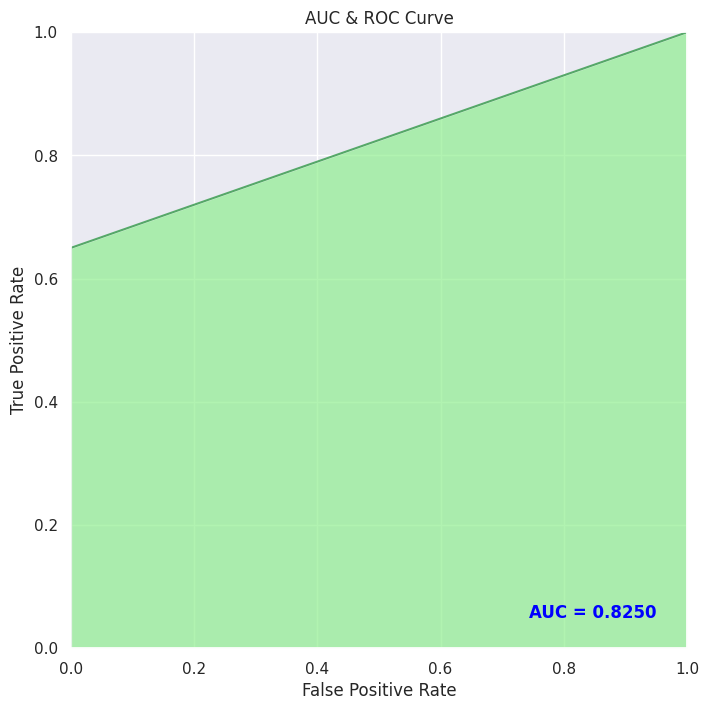

In [19]:
# Plotting AUC and ROC CURVE (for Decision Tree Model)
from sklearn import metrics
aucm = metrics.roc_auc_score(Y_test, PredictedOutput)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(Y_test, PredictedOutput)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % aucm, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [21]:
# Random Forest Classifier model
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)

            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8035573122529645
Best parameters of M, d, m are:  2 5 7
Test accuracy with the best parameters is 0.868421052631579
Test recall with the best parameters is: 0.8
Test AUC with the best parameters is: 0.8722222222222222


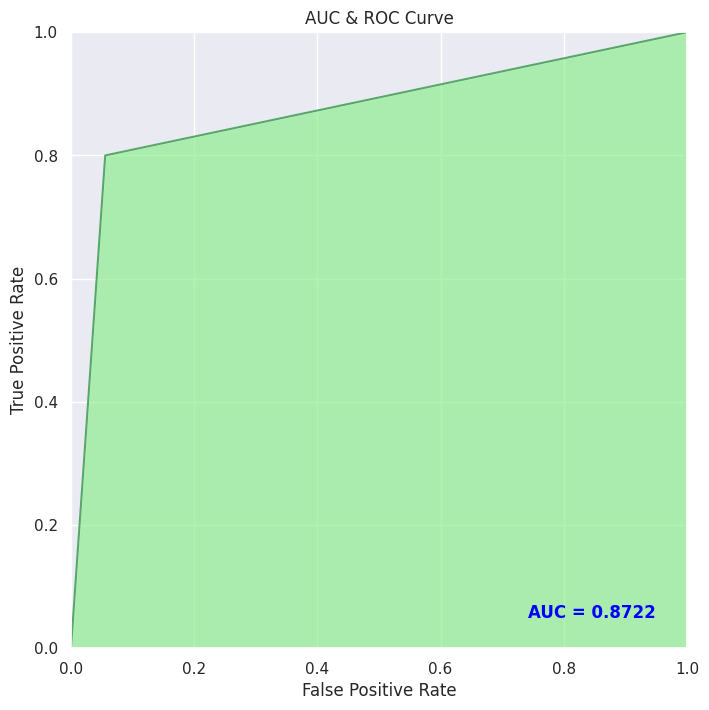

In [22]:
# Plotting AUC and ROC CURVE (for Random Forest CLassifier model)
from sklearn import metrics
aucm = metrics.roc_auc_score(Y_test, PredictedOutput)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(Y_test, PredictedOutput)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % aucm, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [23]:
# Results
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Logistic Regression (w/ imputation),0.789474,0.70,0.794444
1,Logistic Regression (w/ dropna),0.805556,0.75,0.750000
2,Decision Tree,0.815789,0.65,0.825000
3,Random Forest,0.868421,0.80,0.872222
